### Сборный проект - 2

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.  

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно? 

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

##### План работы: 

1) Загрузка и знакомство с данными 

2) Предобработка данных 

3) Изучения и проверка данных 

4) Изучение воронки событий 

5) Изучение результатов эксперимента 

6) Вывод

#### Загрузка и знакомство с данными. 

In [1]:
# Загружаем библиотеки.
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats 
import math as mth

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')

In [3]:
# Знакомимся с данными.
display(data.info())
display(data.head()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


В таблице 244126 записей. Формат данных с столбце EventTimestamp переведем в datetime на одном из следующих этапов, остальные форматы соответствуют типу данных. 
Названия столбцов необходимо будет привести к нижнему регистру и "змеиному" стилю, а также данные в колонке EventName привести к нижнему регистру для поиска неявных дубликатов.

#### Предобработка данных.

In [4]:
# Приводим названия столбцов к нижнему регистру и "змеиному" стилю.
data = data.rename(columns={'EventName':'event_name','DeviceIDHash':'device_id_hash','EventTimestamp':'event_timestamp','ExpId':'exp_id'}) 
data.head()

# Проверяем данные на пропуски.
display(data.isna().sum()) 

# Проверяем на дубликаты и удаляем их.
data['event_name'] = data['event_name'].str.lower() 
display(data.duplicated().sum()) 
data = data.drop_duplicates()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

413

Привели названия столбцов к нижнему регистру и "змеиному" стилю. 

Проверили данные на пропуски - их нет. 

Обнаружили 413 дубликатов, это меньше 2% всех записей в таблице, удалим их.

In [5]:
# Создаем столбцы со временем и датой события. 
data['time'] = pd.to_datetime(data['event_timestamp'], unit='s') 
data['date'] = data['time'].dt.date 
data['date'] = pd.to_datetime(data['date'])
data.info() # Проверяем формат даты 
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   time             243713 non-null  datetime64[ns]
 5   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


,event_name,device_id_hash,event_timestamp,exp_id,time,date
0,mainscreenappear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,mainscreenappear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,paymentscreensuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,cartscreenappear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,paymentscreensuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Создали столбцы со временем события и датой из столбца event_timestamp.

In [6]:
# Проверка на попадание пользователей более чем в одну группу.

group_a = data[data['exp_id']==246] 
group_b = data[data['exp_id']==247] 
group_c = data[data['exp_id']==248] 
common = group_a.merge(group_b, on = ['device_id_hash'])
#common['device_id_hash'].nunique()
common = common.merge(group_c, on= ['device_id_hash'])
common['device_id_hash'].nunique()

0

В каждой группе пользователи уникальны, пересечений между группами нет.

#### Изучение и проверка данных.

243713

7551

32

Timestamp('2019-07-25 00:00:00')

Timestamp('2019-08-07 00:00:00')

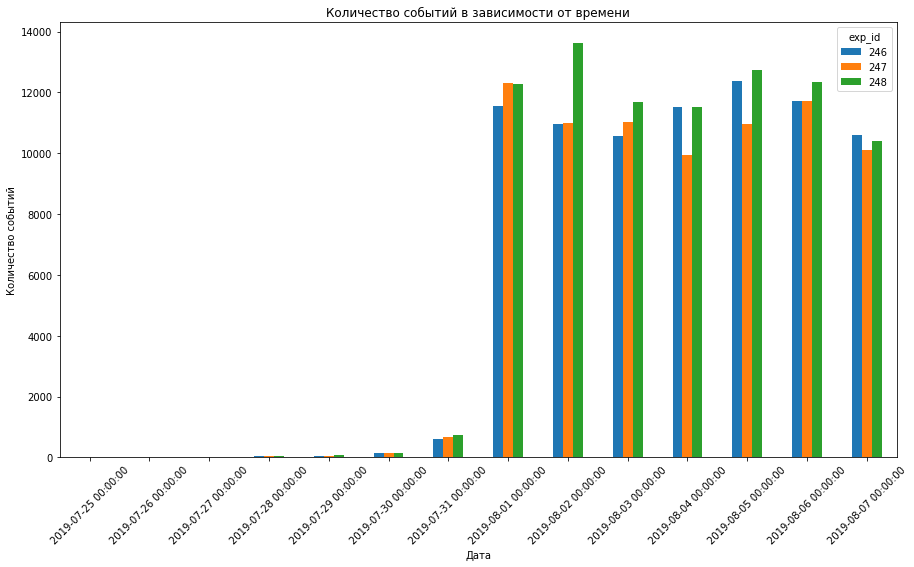

In [7]:
# Количество событий в логе. 
display(data['event_name'].count()) 

# Количество пользователей в логе. 
display(data['device_id_hash'].nunique()) 

# Среднее количество событий на пользователя. 
display(round(data['event_name'].count()/data['device_id_hash'].nunique())) 

# Минимальная и максимальная дата. 
display(data['date'].min()) 
display(data['date'].max()) 

# Диаграмма количества событий в зависимости от времени по группам.
data.pivot_table(index='date',columns='exp_id', values='event_name', aggfunc = 'count').plot(kind='bar', 
xlabel = 'Дата', ylabel = 'Количество событий',figsize = (15,8), title = 'Количество событий в зависимости от времени')
plt.xticks(rotation=45)
plt.show()

Всего событий в логе: 243713

Уникальных пользователей: 7551

Среднее количество событий на пользователя: 32

Минимальная дата: 2019-07-25

Максимальная дата: 2019-08-07 

Данные до 01.08.2019 неполные, можем их убрать изи анализа.

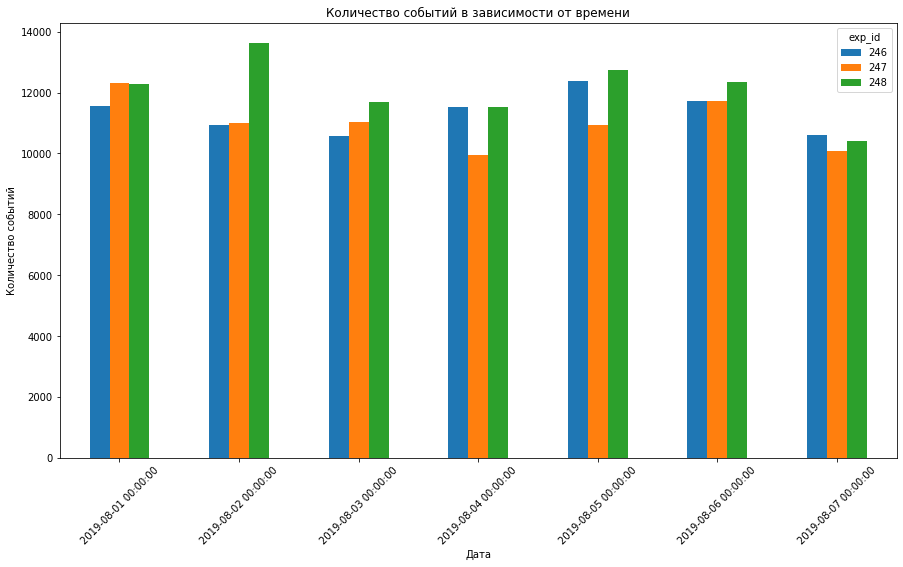

In [8]:
# Убираем нерелевантные данные из анализа.
data_new = data[data['date']>='2019-08-01 00:00:00'] 
data_new.pivot_table(index='date',columns='exp_id', values='event_name', aggfunc = 'count').plot(kind='bar', 
xlabel = 'Дата', ylabel = 'Количество событий',figsize = (15,8), title = 'Количество событий в зависимости от времени')
plt.xticks(rotation=45)
plt.show()

In [9]:
# Проверяем, сколько потерялось событий и пользователей
display(data_new.info())
display(data_new['device_id_hash'].nunique())

# Потерянные события
lost_events = data[data['date']<='31-07-2019']['event_name'].count() 
display(lost_events) 
display((lost_events/data['event_name'].count())*100) # % потерянных событий 

# Потерянные пользователи
lost_users = data['device_id_hash'].nunique() - data_new['device_id_hash'].nunique() 
print(lost_users)
display((lost_users/data['device_id_hash'].nunique())*100) # % потерянных пользователей 


# Проверяем, во всех ли трех группах есть пользователи.
display(data_new.groupby('exp_id')['device_id_hash'].nunique()) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       240887 non-null  object        
 1   device_id_hash   240887 non-null  int64         
 2   event_timestamp  240887 non-null  int64         
 3   exp_id           240887 non-null  int64         
 4   time             240887 non-null  datetime64[ns]
 5   date             240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 12.9+ MB


None

7534

2826

1.159560630741897

17


0.22513574361011784

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

После удаления данных потеряли 2826 событий и 6 уникальных пользователей, т.е. 1.1% событий и 0.22% пользователей, это незначительные показатели. 

Во всех 3-х экспериментальных группах есть пользователи: 

246  -  2484

247  -  2513

248  -  2537

#### Изучение воронки событий. 

In [10]:
# Изучение уникальных событий и частоты их появления.
events = data_new.pivot_table(index='event_name',values='event_timestamp',aggfunc='count').sort_values(by='event_timestamp',ascending=False) 
events = events.rename(columns={'event_timestamp':'event_count'})
events

,event_count
event_name,
mainscreenappear,117328
offersscreenappear,46333
cartscreenappear,42303
paymentscreensuccessful,33918
tutorial,1005


In [11]:
# Количество пользователей, совершавших каждое событие.
users = data_new.pivot_table(index='event_name',values='device_id_hash',aggfunc='nunique').sort_values(by='device_id_hash',
                                                                                                   ascending=False) 
# Доля пользователей, хоть раз совершавших событие.
users['user_ratio'] = round(users['device_id_hash']/data['device_id_hash'].nunique(),2)
users = users.rename(columns={'device_id_hash':'user_count'})

# Общая таблица
merged = events.merge(users, on='event_name') 
merged

,event_count,user_count,user_ratio
event_name,,,
mainscreenappear,117328,7419,0.98
offersscreenappear,46333,4593,0.61
cartscreenappear,42303,3734,0.49
paymentscreensuccessful,33918,3539,0.47
tutorial,1005,840,0.11


Вероятно, события происходят в следующем порядке: 

1) mainscreenappear - показ главного экрана

2) offerscreenappear - показ коммерческого предложения

3) cartscreenappear - показ корзины

4) paymentscreensuccessful - страница с подтверждением платежа

Событие tutorial, судя по всему, не входит в последовательность, его пользователь может совершить в любой момент по желанию.

In [12]:
# Подсчет доли пользователей, которая переходи на следующий шаг воронки.
merged['churn'] = 0

for i in range(0, len(merged['user_count'])):
    if i == 0:
        merged['churn'].iloc[i] = 1 
    else:
        merged['churn'].iloc[i] = round(merged['user_count'].iloc[i]/merged['user_count'].iloc[i-1], 2)
        
display(merged)

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,event_count,user_count,user_ratio,churn
event_name,,,,
mainscreenappear,117328,7419,0.98,1.00
offersscreenappear,46333,4593,0.61,0.62
cartscreenappear,42303,3734,0.49,0.81
paymentscreensuccessful,33918,3539,0.47,0.95
tutorial,1005,840,0.11,0.24


Больше всего пользователей теряется на этапе с предложением товара - переходят туда с главного экрана 62% пользователей. 
От первого события до оплаты доходит (3539/7419 = 0.47) 47% пользователей. 
Большая потеря пользователей на этапе перехода с главного экрана на экран с коммерческим предложением может быть связана с тем, что на главном экране нужная иконка/кнопка, которая переводит на страницу с предложением, неудобно расположена, имеет неочевидный для пользователя функционал, недостаточно заметная и проч. Возможно, стоит обратить на это внимание и внести правки в интерфейс главного экрана.

#### Изучение результатов эксперимента.

In [13]:
# Количество пользователей в каждой экспериментальной группе. 
data_new.groupby('exp_id')['device_id_hash'].nunique() 


exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

In [14]:
# Проверка разницы между группами 246 и 247. 

# Создание таблицы с количеством пользователей на каждом шаге.
exp = data_new.pivot_table(index='exp_id',columns='event_name', values = 'device_id_hash',aggfunc='nunique')
exp['total'] = data_new.pivot_table(index='exp_id', values = 'device_id_hash', aggfunc='nunique')
exp = exp.drop(columns='tutorial').reset_index()
exp 

event_name,exp_id,cartscreenappear,mainscreenappear,offersscreenappear,paymentscreensuccessful,total
0,246,1266,2450,1542,1200,2484
1,247,1238,2476,1520,1158,2513
2,248,1230,2493,1531,1181,2537


Самое популярное событие - mainscreenappear.

Сформулируем гипотезы для всех тестов: 

H0 - разницы между группами нет 

H1 - разница между группами есть 

Установим уровень статистической значимости альфа c поправкой Бонферрони - 0.05/16 = 0.003125. Всего проводим 16 тестов, поэтому делим уровень альфа 0.05 на 16. 

Для проверки гипотез будем использовать z-критерий.

In [15]:
# Функция для проверки групп на различие. 

trials = (exp['total'][0],exp['total'][1])
alpha = .003125 # критический уровень статистической значимости

def equality(successes, trials, alpha):

# пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
    difference = p1 - p2 
    
# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

In [16]:
# Отличие между группами по событию mainscreenappear. 

mainscreenappear = (exp['mainscreenappear'][0],exp['mainscreenappear'][1]) 
equality(mainscreenappear, trials, alpha)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [17]:
# Изучение отличий по остальным событиям.

cartscreenappear = (exp['cartscreenappear'][0],exp['cartscreenappear'][1])
equality(cartscreenappear, trials, alpha)

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [18]:
offersscreenappear = (exp['offersscreenappear'][0],exp['offersscreenappear'][1])  
equality(offersscreenappear, trials, alpha)

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [19]:
paymentscreensuccessful = (exp['paymentscreensuccessful'][0],exp['paymentscreensuccessful'][1]) 
equality(paymentscreensuccessful, trials, alpha)

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам проверки различий между группами 246 и 247 мы не обнаружили. Разбиение на группы работает корректно.

In [20]:
exp246_248 = data[data['exp_id']!=247].pivot_table(index='exp_id',columns='event_name', values = 'device_id_hash',aggfunc='nunique') 
exp246_248

event_name,cartscreenappear,mainscreenappear,offersscreenappear,paymentscreensuccessful,tutorial
exp_id,,,,,
246,1270,2456,1545,1202,279
248,1239,2501,1538,1185,282


In [21]:
# Сравнение групп 246 и 248.

In [22]:
trials1 = (exp['total'][0],exp['total'][2])
mainscreenappear1 = (exp['mainscreenappear'][0],exp['mainscreenappear'][2]) 
equality(mainscreenappear1, trials1, alpha)

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [23]:
cartscreenappear1 = (exp['cartscreenappear'][0],exp['cartscreenappear'][2])
equality(cartscreenappear1, trials1, alpha)

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [24]:
offersscreenappear1 = (exp['offersscreenappear'][0],exp['offersscreenappear'][2])   
equality(offersscreenappear1, trials1, alpha)

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [25]:
paymentscreensuccessful1 = (exp['paymentscreensuccessful'][0],exp['paymentscreensuccessful'][2]) 
equality(paymentscreensuccessful1, trials1, alpha)

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистически значимой разницы между группами 246 и 248 не обнаружено.

In [26]:
# Сравнение групп 247 и 248.

In [27]:
trials2 = (exp['total'][1],exp['total'][2])
mainscreenappear2 = (exp['mainscreenappear'][1],exp['mainscreenappear'][2]) 
equality(mainscreenappear2, trials2, alpha)

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [28]:
cartscreenappear2 = (exp['cartscreenappear'][1],exp['cartscreenappear'][2])
equality(cartscreenappear2, trials2, alpha)

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [29]:
offersscreenappear2 = (exp['offersscreenappear'][1],exp['offersscreenappear'][2]) 
equality(offersscreenappear2, trials2, alpha)

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [30]:
paymentscreensuccessful2 = (exp['paymentscreensuccessful'][1],exp['paymentscreensuccessful'][2])  
equality(paymentscreensuccessful2, trials2, alpha)

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Между группами 247 и 248 статистически значимой разницы также не обнаружили.

In [31]:
# Добавляем строку с данными объединенной контрольной группы. 
exp = exp.reset_index()
exp.loc['combined_control'] = exp.loc[0]+exp.loc[1] 
exp = exp.reset_index()

In [32]:
# Проверка различия между объединенной контрольной и тестовой группой.

trials3 = (exp['total'][3],exp['total'][2])
mainscreenappear3 = (exp['mainscreenappear'][3],exp['mainscreenappear'][2]) 
equality(mainscreenappear3, trials3, alpha)

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [33]:
cartscreenappear3 = (exp['cartscreenappear'][3],exp['cartscreenappear'][2])
equality(cartscreenappear3, trials3, alpha)

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [34]:
offersscreenappear3 = (exp['offersscreenappear'][3],exp['offersscreenappear'][2]) 
equality(offersscreenappear3, trials3, alpha)

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [35]:
paymentscreensuccessful3 = (exp['paymentscreensuccessful'][3],exp['paymentscreensuccessful'][2]) 
equality(paymentscreensuccessful3, trials3, alpha)

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравнение объединенной контрольной и тестовой групп не показало статистически значимых различий.

Мы провели 16 статистических тестов. Для этого эксперимента подходит уровень значимости в 0.05, т.к. при более высоком уровне значимости будет слишком высока вероятности ошибки первого рода.

#### Вывод. 

При анализе использовали данные о 243713 событиях и 7551 пользователях. Пользователи были разделены на 3 группы: 2 контрольные группы и 1 тестовую. Тестовая группа - та, которой показывался вариант приложения с новым шрифтом.

При анализе данных выяснили, что воронка событий выглядит следующим образом: 

1) mainscreenappear - показ главного экрана

2) offerscreenappear - показ коммерческого предложения

3) cartscreenappear - показ корзины

4) paymentscreensuccessful - страница с подтверждением платежа

В результате анализа воронки и конверсии обнаружили, что больше всего пользователей теряется на этапе с предложением товара - переходят туда с главного экрана 62% пользователей. Большая потеря пользователей на этапе перехода с главного экрана на экран с коммерческим предложением может быть связана с тем, что на главном экране нужная иконка/кнопка, которая переводит на страницу с предложением, неудобно расположена, имеет неочевидный для пользователя функционал, недостаточно заметная и проч. Возможно, стоит обратить на это внимание и внести правки в интерфейс главного экрана.

В рамках исследования провели сравнительные тесты между 2-мя контрольными группами, каждой контрольной группой и тестовой и объединенной контрольной группой и тестовой.
Статистически значимых различий между контрольными и тестовой группой по отдельности и объединенной контрольной и тестовой группами мы не обнаружили. Это значит, что изменение шрифта значимо не влияет на конверсию. 